# LANL Research

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gzip
import shutil
import datetime
import networkx as nx

In [2]:
pd.options.display.float_format = '{:,}'.format

### Authentication and Process Data

We neeed to import the data we will use. Below we import the authentication and process summaries.

In [ ]:
rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
frames = []

count = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filedir = rootdir + '/' + file
        with gzip.open(filedir) as f:
            df = pd.read_csv(filedir, header=None)
            frames.append(df)
        if 'authentications' in str(file):
            count = count + len(df)

df = pd.concat(frames)

In [ ]:
df

In [ ]:
authentication_data = df[:count]

In [ ]:
process_data = df[count:]

In [ ]:
authentication_data

In [ ]:
process_data

In [ ]:
def draw_day(data,i):

    # split the data into the selected time period
    df_day = data

    # print day we're working on
    print(i)

    # get all unqiue users for that period
    userlist_1 = list(list(df_day[0].unique()))
    userlist_2 = list(list(df_day[1].unique()))
    unique_users = set(userlist_1 + userlist_2)

    # get all connections made for that period
    connections = zip(df_day[0], df_day[1])

    # create the graph
    G = nx.DiGraph()

    # create the nodes of the graph
    for u in unique_users:
        G.add_node(u)

    # create the edges of the graph
    for a in connections:
        G.add_edge(*a)

    # draw the network
    plt.figure(figsize=(15,15), dpi=400)
    nx.draw(G, node_size=20, linewidths=0.8)
    plt.savefig('day {}.png'.format(i))

    return G

In [ ]:
index_list = authentication_data.index.tolist()
start_days = [i for i, e in enumerate(index_list) if e == 0]
start_days.append(len(authentication_data))

data_ = [(authentication_data[start_days[i]:start_days[i+1]],i) for i in range(len(start_days)-1)]

In [ ]:
begin_time = datetime.datetime.now()
draw_day(data_[0][0], data_[0][1])
print("Finished creating networks!")
end_time = datetime.datetime.now()
print(end_time - begin_time)

Creating a single network takes about 23 minutes. We do this for all 91 days so this is a large process which takes multiple hours so I would not recommend running the below line of code since this has parallelised this process for 8 cores but will still take hours.

In [ ]:
# %run -i Parallelised-Drawing.py

### Netflow Data

In [3]:
path = 'C:/Users/corri/Downloads'
df_netflow = pd.read_csv(path + '/netflow_day-02.bz2', header=None)

In [4]:
headers = (['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol',
            'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes'])
df_netflow.columns = headers

In [5]:
df_netflow

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
0,118781,5580,Comp364445,Comp547245,17,Port05507,Port46272,0,755065,0,1042329018
1,118783,6976,Comp450942,Comp829338,6,Port03137,445,1665,1108,300810,250408
2,118785,14178,IP564116,Comp141988,17,5060,5060,1866,0,1477041,0
3,118785,28147,IP564116,Comp141988,17,5060,5060,3326,0,2656305,0
4,118785,48507,IP564116,Comp141988,17,5060,5060,5423,0,4388449,0
...,...,...,...,...,...,...,...,...,...,...,...
115949431,172799,16505,Comp059508,ActiveDirectory,6,Port78245,Port08664,7958,0,8182300,0
115949432,172799,27496,Comp059508,ActiveDirectory,6,Port78245,Port08664,22893,0,22709439,0
115949433,172799,27548,Comp107130,Comp097048,6,Port05132,443,895,420,105478,29578
115949434,172799,42747,Comp107130,Comp097048,6,Port05132,443,1381,682,154756,41630


We have over 115 million data points and therefore can't run anything without a massive amount of storage - functions such as pd.describe and pd.get_dummies wont work on this. The first steps are therefore to reduce the size of the data we are obtaining.

### Session Host Data

One of the useful pieces of information provided to us by Dan is the session host data. This is a list of computers that were used during the attacks. A first step we can take is to reduce the data set by only keeping the data from these source computers.

In [6]:
sh_file = os.getcwd()[:-4] + 'Data\\session_hosts.txt'
rt_sh = list(pd.read_csv(sh_file, header=None)[0])

In [7]:
rt_src_sh = df_netflow[df_netflow['SrcDevice'].isin(rt_sh)]
#rt_dest_sh = df_netflow[df_netflow['DstDevice'].isin(rt_sh)]
#rt_all = pd.concat([rt_src_sh, rt_dest_sh]).drop_duplicates()

In [8]:
rt_src_sh

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
1083,119484,14156,Comp700191,Comp646861,6,Port42062,443,20491,31292,3935854,41700877
1088,119484,26759,Comp700191,Comp646861,6,Port42062,443,38483,60707,7413244,80878668
1092,119484,46142,Comp700191,Comp646861,6,Port42062,443,67032,111459,12619410,149117906
1095,119484,62707,Comp700191,Comp646861,6,Port42062,443,91147,155143,17091956,207623806
1100,119484,78632,Comp700191,Comp646861,6,Port42062,443,113631,191512,21373274,256098429
...,...,...,...,...,...,...,...,...,...,...,...
115946588,172799,0,Comp939275,Comp275646,17,Port79734,53,1,0,64,0
115947532,172799,1,Comp700191,Comp707645,6,Port10254,443,21,22,7458,13686
115948788,172799,2,Comp819296,Comp186884,6,Port56601,443,0,15,0,7895
115948789,172799,2,Comp819296,Comp186884,6,Port35640,443,0,16,0,8271


In [9]:
f'{261484 * 5 * 90:,}'

'117,667,800'

### Clustering Red Team Session Host Data

In [10]:
# source computers dictionary
src_comps = rt_src_sh['SrcDevice'].unique()
src_comps_dict= {}
for i, key in enumerate(src_comps):
    src_comps_dict[key] = i
    
# destination computers ditionary
dst_comps = rt_src_sh['DstDevice'].unique()
dst_comps_dict= {}
for i, key in enumerate(dst_comps):
    dst_comps_dict[key] = i
    
# source port dictionary
src_port = rt_src_sh['SrcPort'].unique()
src_port_dict= {}
for i, key in enumerate(src_port):
    src_port_dict[key] = i
    
# destination port dictionary
dst_port = rt_src_sh['DstPort'].unique()
dst_port_dict= {}
for i, key in enumerate(dst_port):
    dst_port_dict[key] = i
    
rt_src_sh['SrcDevice'] = rt_src_sh['SrcDevice'].map(src_comps_dict)
rt_src_sh['DstDevice'] = rt_src_sh['DstDevice'].map(dst_comps_dict)
rt_src_sh['SrcPort'] = rt_src_sh['SrcPort'].map(src_port_dict)
rt_src_sh['DstPort'] = rt_src_sh['DstPort'].map(dst_port_dict)

In [11]:
rt_src_sh['SrcDevice'] = rt_src_sh['SrcDevice'].map(src_comps_dict)
rt_src_sh['DstDevice'] = rt_src_sh['DstDevice'].map(dst_comps_dict)
rt_src_sh['SrcPort'] = rt_src_sh['SrcPort'].map(src_port_dict)
rt_src_sh['DstPort'] = rt_src_sh['DstPort'].map(dst_port_dict)

<ipython-input-11-d50627209351>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_src_sh['SrcDevice'] = rt_src_sh['SrcDevice'].map(src_comps_dict)
<ipython-input-11-d50627209351>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_src_sh['DstDevice'] = rt_src_sh['DstDevice'].map(dst_comps_dict)
<ipython-input-11-d50627209351>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [12]:
rt_src_sh.dtypes

Time          int64
Duration      int64
SrcDevice     int64
DstDevice     int64
Protocol      int64
SrcPort       int64
DstPort       int64
SrcPackets    int64
DstPackets    int64
SrcBytes      int64
DstBytes      int64
dtype: object

In [23]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=10, min_samples=5).fit(rt_src_sh)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 612
Estimated no. of noise points: 255038


In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=2)

In [26]:
pca.fit(rt_src_sh)
rt_sh_trans = pca.transform(rt_src_sh)

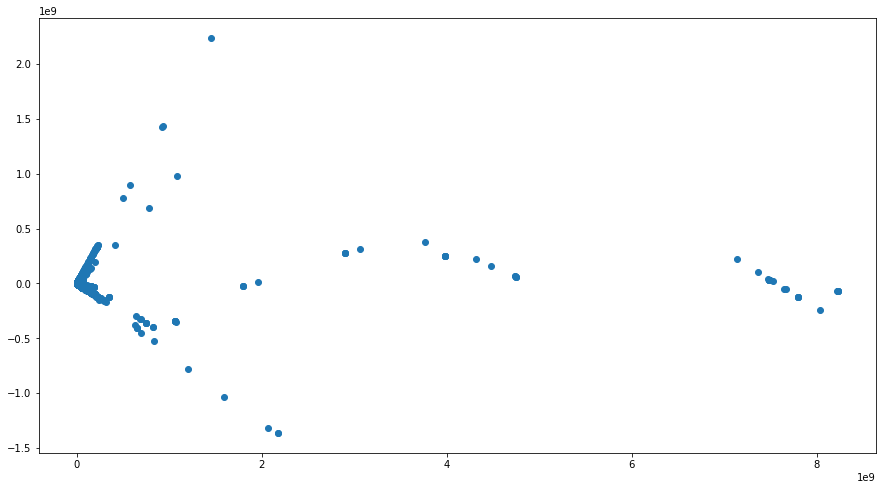

In [27]:
fig = plt.figure(figsize=(15, 8))
plt.scatter(rt_sh_trans[:, 0], rt_sh_trans[:, 1])
plt.show()

#### Source Devices

In [ ]:
src_device_counts = df_netflow.groupby('SrcDevice').size().sort_values(ascending=False)

In [ ]:
src_device_counts.index

In [ ]:
src_device_20l = src_device_counts.nlargest(20)

In [ ]:
plt.figure(figsize=(12,12))
plt.pie(src_device_20l, labels=src_device_20l.index, autopct = '%.2f')
plt.title('Pie chart showing the percentage contribution of the top 20 source computers')
plt.show()

### Time

In [ ]:
duration_data = df_netflow['Duration']
fig1, ax1 = plt.subplots()
ax1.set_title('Box Plot of Duration data')
ax1.boxplot(duration_data)

In [ ]:
dur_mean = df_netflow['Duration'].mean()
dur_75 = np.percentile(df_netflow['Duration'], 75)
dur_25 = np.percentile(df_n)